# Samruk Green 5MW Wind Station Dataset and Model preparation

# Dataset Preprocessing

In [1]:
import os
import numpy as np
import pandas as pd
import warnings
from openpyxl import Workbook

# Suppress the warnings
warnings.simplefilter("ignore", category=UserWarning)

# Directory path
dir_path = 'C:/Users/Shon/Desktop/TGS-ENERGY Forecast Analysis/Intech-Forecast/Самрук Грин ВЭС/Samruk_Green_Historical_Data/'

In [2]:
files = os.listdir(dir_path)

# List to store processed DataFrames
dfs = []

In [3]:
# Loop over each file and process
for file in files:
    if file.endswith('.xlsx'):
        # Complete file path
        file_path = os.path.join(dir_path, file)
        
        # Read the Excel file
        df = pd.read_excel(file_path)
        
        # Process the data as in your code
        df.drop([0,1], axis=0, inplace=True)
        df['Unnamed: 4'] = pd.to_datetime(df['Unnamed: 4'], format='%Y-%m-%d %H', errors='coerce')
        power = df.pivot(index='Unnamed: 4', columns='Unnamed: 1', values='Unnamed: 6')
        wind_speed = df.pivot(index='Unnamed: 4', columns='Unnamed: 1', values='Unnamed: 5')
        wind_direction = df.pivot(index='Unnamed: 4', columns='Unnamed: 1', values='Unnamed: 7')
        wind_angle = df.pivot(index='Unnamed: 4', columns='Unnamed: 1', values='Unnamed: 8')
        result = pd.concat([power, wind_speed, wind_direction, wind_angle], axis=1)
        result.drop(columns='--', inplace=True)
        result.columns=['Line 1_Power','Line 2_Power','Line 1_WindSpeed','Line 2_WindSpeed','Line 1_WindDir','Line 2_WindDir','Line 1_WindAngle','Line 2_WindAngle']
        dfs.append(result)

In [4]:
# Concatenate all processed DataFrames into one
final_df = pd.concat(dfs)

In [5]:
print(final_df.index)

DatetimeIndex([                'NaT', '2021-08-01 00:00:00',
               '2021-08-01 01:00:00', '2021-08-01 02:00:00',
               '2021-08-01 03:00:00', '2021-08-01 04:00:00',
               '2021-08-01 05:00:00', '2021-08-01 06:00:00',
               '2021-08-01 07:00:00', '2021-08-01 08:00:00',
               ...
               '2023-01-31 14:00:00', '2023-01-31 15:00:00',
               '2023-01-31 16:00:00', '2023-01-31 17:00:00',
               '2023-01-31 18:00:00', '2023-01-31 19:00:00',
               '2023-01-31 20:00:00', '2023-01-31 21:00:00',
               '2023-01-31 22:00:00', '2023-01-31 23:00:00'],
              dtype='datetime64[ns]', name='Unnamed: 4', length=26130, freq=None)


# Final Sorted Dataset to be Used

In [6]:
final_df=pd.DataFrame(final_df)

final_df_sorted = final_df.sort_values(by='Unnamed: 4')
final_df_sorted.fillna(0,inplace=True)
final_df_sorted

,Line 1_Power,Line 2_Power,Line 1_WindSpeed,Line 2_WindSpeed,Line 1_WindDir,Line 2_WindDir,Line 1_WindAngle,Line 2_WindAngle
Unnamed: 4,,,,,,,,
2020-09-13 00:00:00,1497.83,1527.08,8.55,8.63,0,0,181.36,181.43
2020-09-13 01:00:00,853.24,859.25,6.75,6.81,0,0,183.38,180.75
2020-09-13 02:00:00,922.20,967.82,6.83,6.98,0,0,177.73,178.24
2020-09-13 03:00:00,576.67,592.68,5.79,5.94,0,0,179.60,179.79
2020-09-13 04:00:00,161.72,166.33,3.22,3.47,0,0,172.73,153.76
...,...,...,...,...,...,...,...,...
NaT,0.00,0.00,0.00,0.00,0,0,0.00,0.00
NaT,0.00,0.00,0.00,0.00,0,0,0.00,0.00
NaT,0.00,0.00,0.00,0.00,0,0,0.00,0.00


# Correlation Matrix for the Dataset

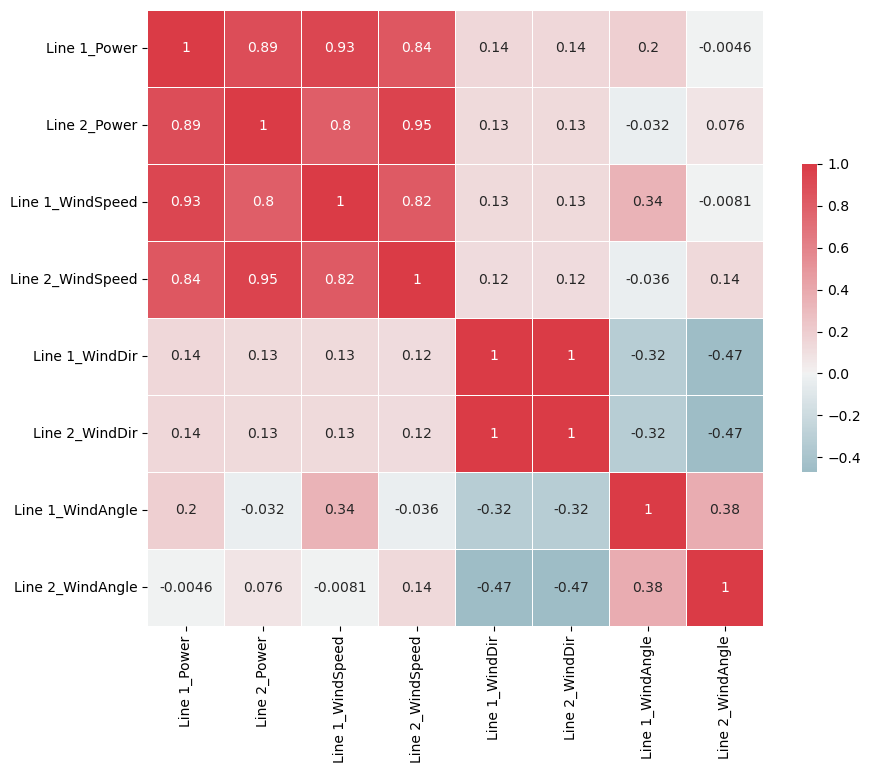

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = final_df_sorted.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

# XGBoost Model with Hyperparameters

In [8]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# Features and Target variable
X = final_df_sorted[['Line 1_WindSpeed', 'Line 1_WindDir']]
y = final_df_sorted['Line 1_Power']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
model = xgb.XGBRegressor(objective='reg:squarederror')

param_grid = {
    'learning_rate': [0.01, 0.2],
    'max_depth': [1,3, 5],
    'n_estimators' : [60, 150],
    'subsample': [1.0],
}

grid_clf = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_clf.fit(X_train, y_train)

# Get the best parameters
best_params = grid_clf.best_params_
print(f"Best parameters: {best_params}")

# Train the model with the best parameters
best_model = xgb.XGBRegressor(**best_params, objective='reg:squarederror')
best_model.fit(X_train, y_train)

# Predict on test data
y_pred = best_model.predict(X_test)

# Measure the performance
mse = mean_squared_error(y_test, y_pred)
avg_power = y_test.mean()

print(f"Mean Squared Error: {mse}")
print(f"Average Power: {avg_power:.2f}")
print(y_pred)

Best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 60, 'subsample': 1.0}
Mean Squared Error: 38579.10988689735
Average Power: 787.16
[-3.1539936e+00 -6.3097721e-01 -3.1539936e+00 ...  4.1178879e+02
  1.0226647e+02  6.3869275e+02]


# XGBoost model with Hyperparameters for Lines 1 and 2

In [17]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# Features and Target variable for Line 1
X1 = final_df_sorted['Line 1_WindSpeed']
y1 = final_df_sorted['Line 1_Power']

# Features and Target variable for Line 2
X2 = final_df_sorted['Line 2_WindSpeed']
y2 = final_df_sorted['Line 2_Power']

# Split the data into train and test sets for Line 1
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=100)

# Split the data into train and test sets for Line 2
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=100)

# Train the model for Line 1
model1 = xgb.XGBRegressor(objective='reg:squarederror')

param_grid = {
    'learning_rate': [0.01, 0.2],
    'max_depth': [1, 3, 5],
    'n_estimators': [60, 150],
    'subsample': [1.0],
}

grid_clf = GridSearchCV(model1, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_clf.fit(X_train1, y_train1)

# Get the best parameters for Line 1
best_params1 = grid_clf.best_params_
print(f"Best parameters for Line 1: {best_params1}")

# Train the model with the best parameters for Line 1
best_model1 = xgb.XGBRegressor(**best_params1, objective='reg:squarederror')
best_model1.fit(X_train1, y_train1)

# Predict on test data for Line 1
y_pred1 = best_model1.predict(X_test1)

# Measure the performance for Line 1
mse1 = mean_squared_error(y_test1, y_pred1)
avg_power1 = y_test1.mean()

print(f"Mean Squared Error for Line 1: {mse1}")
print(f"Average Power for Line 1: {avg_power1:.2f}")

# Train the model for Line 2
model2 = xgb.XGBRegressor(objective='reg:squarederror')

grid_clf.fit(X_train2, y_train2)

# Get the best parameters for Line 2
best_params2 = grid_clf.best_params_
print(f"Best parameters for Line 2: {best_params2}")

# Train the model with the best parameters for Line 2
best_model2 = xgb.XGBRegressor(**best_params2, objective='reg:squarederror')
best_model2.fit(X_train2, y_train2)

# Predict on test data for Line 2
y_pred2 = best_model2.predict(X_test2)

# Measure the performance for Line 2
mse2 = mean_squared_error(y_test2, y_pred2)
avg_power2 = y_test2.mean()

print(f"Mean Squared Error for Line 2: {mse2}")
print(f"Average Power for Line 2: {avg_power2:.2f}")

Best parameters for Line 1: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 60, 'subsample': 1.0}
Mean Squared Error for Line 1: 38684.78005567489
Average Power for Line 1: 787.16
Best parameters for Line 2: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 60, 'subsample': 1.0}
Mean Squared Error for Line 2: 19800.028270236802
Average Power for Line 2: 868.85


# XGBoost model without tuning parameters

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Features and Target variable
X = final_df_sorted[['Line 1_WindSpeed', 'Line 1_WindDir','Line 1_WindAngle']]
y = final_df_sorted['Line 1_Power']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

# Create and train the model
model = xgb.XGBRegressor(objective ='reg:squarederror')
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Measure the performance
mse = mean_squared_error(y_test, y_pred)
percentage_errors = abs((y_pred - y_test) / y_test) * 100
avg_power = y_test.mean()

# Compute the Mean Absolute Percentage Error (MAPE)
mape = percentage_errors.mean()

print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Mean Squared Error: {mse}")
print(f"Average Power: {avg_power:.2f}")

# Light Boosting Model with Hyperparameters

In [29]:
!pip install lightgbm

In [35]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# Features and Target variable
X = final_df_sorted['Line 2_WindSpeed']
y = final_df_sorted['Line 2_Power']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
X_train = X_train.values.reshape(-1,1)
X_test = X_test.values.reshape(-1,1)

model = lgb.LGBMRegressor(objective='regression')

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'n_estimators' : [100, 200, 500],
}

grid_clf = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_clf.fit(X_train, y_train)

# Get the best parameters
best_params = grid_clf.best_params_
print(f"Best parameters: {best_params}")

# Train the model with the best parameters
best_model = lgb.LGBMRegressor(**best_params, objective='regression')
best_model.fit(X_train, y_train)

# Predict on test data
y_pred = best_model.predict(X_test)

# Measure the performance
mse = mean_squared_error(y_test, y_pred)
avg_power = y_test.mean()

print(f"Mean Squared Error: {mse}")
print(f"Average Power: {avg_power:.2f}")

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 20904, number of used features: 1
[LightGBM] [Info] Start training from score 894.009429
Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 500}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 20904, number of used features: 1
[LightGBM] [Info] Start training from score 894.009429
Mean Squared Error: 19769.34381138096
Average Power: 868.85


# Random Forest Model with Hyperparameters

In [37]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

# Features and Target variable
X = final_df_sorted['Line 2_WindSpeed']
y = final_df_sorted['Line 2_Power']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
X_train = X_train.values.reshape(-1,1)
X_test = X_test.values.reshape(-1,1)

# Initialize the model
model = RandomForestRegressor()

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 20, 30],
    'min_samples_split': [3, 7, 13],
    'min_samples_leaf': [1, 2, 4],
}

grid_clf = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_clf.fit(X_train, y_train)

# Get the best parameters
best_params = grid_clf.best_params_
print(f"Best parameters: {best_params}")

# Train the model with the best parameters
best_model = RandomForestRegressor(**best_params)
best_model.fit(X_train, y_train)

# Predict on test data
y_pred = best_model.predict(X_test)

# Measure the performance
mse = mean_squared_error(y_test, y_pred)
avg_power = y_test.mean()

print(f"Mean Squared Error: {mse}")
print(f"Average Power: {avg_power:.2f}")

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 13, 'n_estimators': 200}
Mean Squared Error: 21063.564671467237
Average Power: 868.85


# SVM (Support Vector Machine) model 

In [20]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Features and Target variable
X = final_df_sorted['Line 1_WindSpeed']
y = final_df_sorted['Line 1_Power']

# It's typically a good idea to scale the data when using SVR
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=100)

# Initialize the model
model = SVR()

# Define hyperparameter grid
param_grid = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [0.1, 1, 5],
    'epsilon': [0.01, 0.1],
    'degree': [2, 3, 4]  # Only used when kernel is 'poly'
}

grid_clf = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_clf.fit(X_train, y_train)

# Get the best parameters
best_params = grid_clf.best_params_
print(f"Best parameters: {best_params}")

# Train the model with the best parameters
best_model = SVR(**best_params)
best_model.fit(X_train, y_train)

# Predict on test data
y_pred_scaled = best_model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Measure the performance
mse = mean_squared_error(scaler_y.inverse_transform(y_test), y_pred)
avg_power = scaler_y.inverse_transform(y_test).mean()

print(f"Mean Squared Error: {mse}")
print(f"Average Power: {avg_power:.2f}")

ValueError: Expected 2D array, got 1D array instead:
array=[8.55 6.75 6.83 ... 0.   0.   0.  ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [30]:
import requests
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# Function to fetch weather forecasts from Solcast.com API
def fetch_weather_forecasts(api_key, latitude, longitude):
    url = f'https://api.solcast.com.au/data/forecast/radiation_and_weather?latitude=43.644816&longitude=78.537440&output_parameters=wind_speed_10m,wind_direction_10m,wind_speed_100m,wind_direction_100m&api_key=puk_5GMCXCS-Im06WxfUf8LDp6_6mQ4E&format=json' 
    response = requests.get(url)
    
    if response.status_code == 200:
        data = response.json()
        return data
    else:
        raise Exception(f"Failed to fetch weather forecasts. Status code: {response.status_code}")

# Your Solcast API key, latitude, and longitude
solcast_api_key = 'puk_5GMCXCS-Im06WxfUf8LDp6_6mQ4E'
latitude = 43.644816
longitude = 78.537440

# Fetch weather forecasts from Solcast
weather_data = fetch_weather_forecasts(solcast_api_key, latitude, longitude)

# Create a DataFrame from the weather data
weather_df = pd.DataFrame(weather_data['forecasts'])

# Assume that 'wind_speed' and 'wind_direction' are keys in the weather data
wind_speed_forecast = weather_df['wind_speed_10m'].values
wind_direction_forecast = weather_df['wind_direction_10m'].values

# Create a DataFrame with input features for the next day
forecast_input = pd.DataFrame({
    'Line 1_WindSpeed': wind_speed_forecast,
    'Line 1_WindDir': wind_direction_forecast,
    'Line 1_WindAngle': np.zeros_like(wind_speed_forecast)  # You may replace this with actual data if available
})

# Load your trained XGBoost model (best_model)
# You can save and load the model using joblib or pickle
# Example: best_model = joblib.load('your_model_file.joblib')

# Define and train the XGBoost model
# Features and Target variable
X = final_df_sorted[['Line 1_WindSpeed', 'Line 1_WindDir','Line 1_WindAngle']]
y = final_df_sorted['Line 1_Power']

# Split the data into train and test sets (you may need to adjust this)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
model = xgb.XGBRegressor(objective='reg:squarederror')

param_grid = {
    'learning_rate': [0.01, 0.2],
    'max_depth': [1,3, 5],
    'n_estimators' : [60, 150],
    'subsample': [1.0],
}

grid_clf = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_clf.fit(X_train, y_train)

# Get the best parameters
best_params = grid_clf.best_params_
print(f"Best parameters: {best_params}")

# Train the model with the best parameters
best_model = xgb.XGBRegressor(**best_params, objective='reg:squarederror')
best_model.fit(X_train, y_train)

# Generate forecasts for the next day
power_forecasts = best_model.predict(forecast_input)

# You now have power forecasts for each hour of the next day in 'power_forecasts'

# Print or use the forecasts as needed
print(power_forecasts)

Exception: Failed to fetch weather forecasts. Status code: 402

# 48 Hours Forecasts using Openweather's API

In [54]:
import requests
import pandas as pd

# Define the API endpoint and your API key
api_url = 'https://api.openweathermap.org/data/3.0/onecall?'
api_key = '22aad5dd601878f2c4827484ff1bdd80'  # Replace with your actual API key

# Define the latitude and longitude of the location you want to get weather data for
latitude = '43.644816'    # Replace with the actual latitude
longitude = '78.537440'  # Replace with the actual longitude

# Define the parameters for the API request
params = {
    'lat': latitude,
    'lon': longitude,
    'exclude': 'current,minutely,daily',
    'appid': api_key,
    'units': 'metric'  # You can change to 'imperial' for Fahrenheit
}

# Send a GET request to the API
response = requests.get(api_url, params=params)

# Check if the request was successful
if response.status_code == 200:
    # Parse the JSON response
    weather_data = response.json()
    print(weather_data)
else:
    print('Failed to retrieve weather data. Status code:', response.status_code)

{'cod': '200', 'message': 0, 'cnt': 96, 'list': [{'dt': 1697205600, 'main': {'temp': 11.28, 'feels_like': 10.71, 'temp_min': 9.29, 'temp_max': 11.28, 'pressure': 1025, 'sea_level': 1025, 'grnd_level': 961, 'humidity': 86, 'temp_kf': 1.99}, 'weather': [{'id': 500, 'main': 'Rain', 'description': 'light rain', 'icon': '10n'}], 'clouds': {'all': 100}, 'wind': {'speed': 13.39, 'deg': 259, 'gust': 17.49}, 'visibility': 10000, 'pop': 0.48, 'rain': {'1h': 0.19}, 'sys': {'pod': 'n'}, 'dt_txt': '2023-10-13 14:00:00'}, {'dt': 1697209200, 'main': {'temp': 10.56, 'feels_like': 9.89, 'temp_min': 8.73, 'temp_max': 10.56, 'pressure': 1026, 'sea_level': 1026, 'grnd_level': 962, 'humidity': 85, 'temp_kf': 1.83}, 'weather': [{'id': 500, 'main': 'Rain', 'description': 'light rain', 'icon': '10n'}], 'clouds': {'all': 100}, 'wind': {'speed': 12.39, 'deg': 260, 'gust': 16.32}, 'visibility': 10000, 'pop': 0.52, 'rain': {'1h': 0.2}, 'sys': {'pod': 'n'}, 'dt_txt': '2023-10-13 15:00:00'}, {'dt': 1697212800, 'mai

In [55]:
import requests
import pandas as pd

# Define the API endpoint and your API key
api_url = 'https://api.openweathermap.org/data/3.0/onecall?'
api_key = '22aad5dd601878f2c4827484ff1bdd80'  # Replace with your actual API key

# Define the latitude and longitude of the location you want to get weather data for
latitude = '43.644816'    # Replace with the actual latitude
longitude = '78.537440'  # Replace with the actual longitude

# Define the parameters for the API request
params = {
    'lat': latitude,
    'lon': longitude,
    'exclude': 'current,minutely,daily',
    'appid': api_key,
    'units': 'metric'  # You can change to 'imperial' for Fahrenheit
}

# Send a GET request to the API
response = requests.get(api_url, params=params)

# Check if the request was successful
if response.status_code == 200:
    # Parse the JSON response
    weather_data = response.json()

    # Extract the hourly data
    hourly_data = weather_data['hourly']

    # Initialize an empty list to store the data
    data = []

    # Loop through the hourly data and extract the relevant information
    for hour in hourly_data:
        data.append({
            'timestamp': hour['dt'],
            'temp': hour['temp'],
            'feels_like': hour['feels_like'],
            'pressure': hour['pressure'],
            'humidity': hour['humidity'],
            'dew_point': hour['dew_point'],
            'uvi': hour['uvi'],
            'clouds': hour['clouds'],
            'visibility': hour['visibility'],
            'wind_speed': hour['wind_speed'],
            'wind_deg': hour['wind_deg'],
            'wind_gust': hour['wind_gust'],
            'weather_description': hour['weather'][0]['description'],
            'weather_icon': hour['weather'][0]['icon'],
            'pop': hour['pop']
        })

    # Create a Pandas DataFrame from the list of dictionaries
    df_weather = pd.DataFrame(data)

    # Print the DataFrame
    print(df_weather)

else:
    print('Failed to retrieve weather data. Status code:', response.status_code)

KeyError: 'hourly'

In [46]:
timezone_offset = 21600  # 21,600 seconds

# Add a new column 'timestamp_KZ' by applying the offset
df_weather['timestamp_KZ'] = df_weather['timestamp'] + timezone_offset

# Display the updated DataFrame
print(df_weather)

     timestamp   temp  feels_like  pressure  humidity  dew_point   uvi  \
0   1697202000  11.78       11.29      1025        87       9.69  0.00   
1   1697205600  11.28       10.71      1025        86       9.03  0.00   
2   1697209200  10.56        9.89      1026        85       8.15  0.00   
3   1697212800   9.59        5.25      1027        82       6.67  0.00   
4   1697216400   8.62        4.16      1028        83       5.90  0.00   
5   1697220000   7.30        2.61      1029        84       3.76  0.00   
6   1697223600   6.85        2.13      1030        86       3.83  0.00   
7   1697227200   6.87        2.30      1030        88       4.03  0.00   
8   1697230800   6.97        2.48      1030        88       4.06  0.00   
9   1697234400   6.84        2.45      1030        89       4.15  0.00   
10  1697238000   6.76        2.38      1030        88       4.03  0.00   
11  1697241600   6.75        2.53      1030        86       3.68  0.00   
12  1697245200   6.66        2.43     

In [48]:
df_weather['timestamp_KZ'] = pd.to_datetime(df_weather['timestamp_KZ'], unit='s').dt.strftime('%Y-%m-%d %H:%M:%S')

# Print the modified DataFrame
print(df_weather)

ValueError: non convertible value 2023-10-13 19:00:00 with the unit 's'

In [49]:
# Assuming you have a DataFrame called 'weather_forecast' with 'wind_speed' and 'wind_deg' columns
# You can preprocess it to match your model's feature names

# Rename columns
df_weather = df_weather.rename(columns={'wind_speed': 'Line 1_WindSpeed', 'wind_deg': 'Line 1_WindDir'})
print(df_weather)

     timestamp   temp  feels_like  pressure  humidity  dew_point   uvi  \
0   1697202000  11.78       11.29      1025        87       9.69  0.00   
1   1697205600  11.28       10.71      1025        86       9.03  0.00   
2   1697209200  10.56        9.89      1026        85       8.15  0.00   
3   1697212800   9.59        5.25      1027        82       6.67  0.00   
4   1697216400   8.62        4.16      1028        83       5.90  0.00   
5   1697220000   7.30        2.61      1029        84       3.76  0.00   
6   1697223600   6.85        2.13      1030        86       3.83  0.00   
7   1697227200   6.87        2.30      1030        88       4.03  0.00   
8   1697230800   6.97        2.48      1030        88       4.06  0.00   
9   1697234400   6.84        2.45      1030        89       4.15  0.00   
10  1697238000   6.76        2.38      1030        88       4.03  0.00   
11  1697241600   6.75        2.53      1030        86       3.68  0.00   
12  1697245200   6.66        2.43     

In [50]:
# Now rename the original columns
df_weather = df_weather.rename(columns={'wind_speed': 'Line 1_WindSpeed', 'wind_deg': 'Line 1_WindDir'})

# Duplicate and rename the columns
df_weather['Line 2_WindSpeed'] = df_weather['Line 1_WindSpeed']
df_weather['Line 2_WindDir'] = df_weather['Line 1_WindDir']

# Print the DataFrame
print(df_weather)

     timestamp   temp  feels_like  pressure  humidity  dew_point   uvi  \
0   1697202000  11.78       11.29      1025        87       9.69  0.00   
1   1697205600  11.28       10.71      1025        86       9.03  0.00   
2   1697209200  10.56        9.89      1026        85       8.15  0.00   
3   1697212800   9.59        5.25      1027        82       6.67  0.00   
4   1697216400   8.62        4.16      1028        83       5.90  0.00   
5   1697220000   7.30        2.61      1029        84       3.76  0.00   
6   1697223600   6.85        2.13      1030        86       3.83  0.00   
7   1697227200   6.87        2.30      1030        88       4.03  0.00   
8   1697230800   6.97        2.48      1030        88       4.06  0.00   
9   1697234400   6.84        2.45      1030        89       4.15  0.00   
10  1697238000   6.76        2.38      1030        88       4.03  0.00   
11  1697241600   6.75        2.53      1030        86       3.68  0.00   
12  1697245200   6.66        2.43     

In [51]:
# Make predictions on the weather forecast data
energy_forecasts_1 = best_model1.predict(df_weather[['Line 1_WindSpeed', 'Line 1_WindDir']])
energy_forecasts_2 = best_model2.predict(df_weather[['Line 2_WindSpeed', 'Line 2_WindDir']])

# Add the energy forecasts to the weather DataFrame
df_weather['Line 1_Power_Forecast'] = energy_forecasts_1
df_weather['Line 2_Power_Forecast'] = energy_forecasts_2
df_weather['Total_Power_Forecast']=(df_weather['Line 1_Power_Forecast'] + df_weather['Line 2_Power_Forecast'])
print(df_weather)

     timestamp   temp  feels_like  pressure  humidity  dew_point   uvi  \
0   1697202000  11.78       11.29      1025        87       9.69  0.00   
1   1697205600  11.28       10.71      1025        86       9.03  0.00   
2   1697209200  10.56        9.89      1026        85       8.15  0.00   
3   1697212800   9.59        5.25      1027        82       6.67  0.00   
4   1697216400   8.62        4.16      1028        83       5.90  0.00   
5   1697220000   7.30        2.61      1029        84       3.76  0.00   
6   1697223600   6.85        2.13      1030        86       3.83  0.00   
7   1697227200   6.87        2.30      1030        88       4.03  0.00   
8   1697230800   6.97        2.48      1030        88       4.06  0.00   
9   1697234400   6.84        2.45      1030        89       4.15  0.00   
10  1697238000   6.76        2.38      1030        88       4.03  0.00   
11  1697241600   6.75        2.53      1030        86       3.68  0.00   
12  1697245200   6.66        2.43     

In [53]:
# Assuming you have a DataFrame named 'weather_forecast' and you want to export it to an Excel file
excel_filename = 'C:/Users/Shon/Desktop/TGS-ENERGY Forecast Analysis/Intech-Forecast/Самрук Грин ВЭС/samruk_green_forecasts/power_forecasts_2_2.xlsx'  # Provide the desired Excel file name

# Use the to_excel function to export the DataFrame to an Excel file
df_weather.to_excel(excel_filename, index=False)

# 96 Hours Forecasts using Openweather's API

In [21]:
import requests
import pandas as pd
from pandas import json_normalize

# Define the API endpoint and your API key
api_url = 'https://pro.openweathermap.org/data/2.5/forecast/hourly?'
api_key = '22aad5dd601878f2c4827484ff1bdd80'  # Replace with your actual API key

# Define the latitude and longitude of the location you want to get weather data for
latitude = '43.644816'    # Replace with the actual latitude
longitude = '78.537440'  # Replace with the actual longitude

# Define the parameters for the API request
params = {
    'lat': latitude,
    'lon': longitude,
    'exclude': 'current,minutely,daily',
    'appid': api_key,
    'units': 'metric'  # You can change to 'imperial' for Fahrenheit
}

# Send a GET request to the API
response = requests.get(api_url, params=params)

# Check if the request was successful
if response.status_code == 200:
    # Parse the JSON response
    weather_data = response.json()
    print(weather_data)
else:
    print('Failed to retrieve weather data. Status code:', response.status_code)

{'cod': '200', 'message': 0, 'cnt': 96, 'list': [{'dt': 1697364000, 'main': {'temp': 14.06, 'feels_like': 12.62, 'temp_min': 14.06, 'temp_max': 14.12, 'pressure': 1023, 'sea_level': 1023, 'grnd_level': 958, 'humidity': 42, 'temp_kf': -0.06}, 'weather': [{'id': 802, 'main': 'Clouds', 'description': 'scattered clouds', 'icon': '03d'}], 'clouds': {'all': 50}, 'wind': {'speed': 2.79, 'deg': 40, 'gust': 2.5}, 'visibility': 10000, 'pop': 0, 'sys': {'pod': 'd'}, 'dt_txt': '2023-10-15 10:00:00'}, {'dt': 1697367600, 'main': {'temp': 13.95, 'feels_like': 12.52, 'temp_min': 13.82, 'temp_max': 13.95, 'pressure': 1023, 'sea_level': 1023, 'grnd_level': 958, 'humidity': 43, 'temp_kf': 0.13}, 'weather': [{'id': 803, 'main': 'Clouds', 'description': 'broken clouds', 'icon': '04d'}], 'clouds': {'all': 51}, 'wind': {'speed': 1.99, 'deg': 34, 'gust': 1.89}, 'visibility': 10000, 'pop': 0, 'sys': {'pod': 'd'}, 'dt_txt': '2023-10-15 11:00:00'}, {'dt': 1697371200, 'main': {'temp': 13.03, 'feels_like': 11.62, 

In [22]:
weather_df = json_normalize(weather_data['list'])

In [23]:
timezone_offset = 21600  # 21,600 seconds

# Add a new column 'timestamp_KZ' by applying the offset
weather_df['timestamp_KZ'] = weather_df['dt'] + timezone_offset

# Display the updated DataFrame

In [24]:
weather_df['timestamp_KZ'] = pd.to_datetime(weather_df['timestamp_KZ'], unit='s').dt.strftime('%Y-%m-%d %H:%M:%S')

# Print the modified DataFrame

In [25]:
# Now rename the original columns
weather_df = weather_df.rename(columns={'wind.speed': 'Line 1_WindSpeed'})

# Duplicate and rename the columns
weather_df['Line 2_WindSpeed'] = weather_df['Line 1_WindSpeed']

# Print the DataFrame

In [26]:
# Make predictions on the weather forecast data
energy_forecasts_1 = best_model1.predict(weather_df['Line 1_WindSpeed'])
energy_forecasts_2 = best_model2.predict(weather_df['Line 2_WindSpeed'])

# Add the energy forecasts to the weather DataFrame
weather_df['Line 1_Power_Forecast'] = energy_forecasts_1
weather_df['Line 2_Power_Forecast'] = energy_forecasts_2
weather_df['Total_Power_Forecast']=(weather_df['Line 1_Power_Forecast'] + weather_df['Line 2_Power_Forecast'])
print(weather_df)

            dt                                            weather  visibility  \
0   1697364000  [{'id': 802, 'main': 'Clouds', 'description': ...       10000   
1   1697367600  [{'id': 803, 'main': 'Clouds', 'description': ...       10000   
2   1697371200  [{'id': 802, 'main': 'Clouds', 'description': ...       10000   
3   1697374800  [{'id': 802, 'main': 'Clouds', 'description': ...       10000   
4   1697378400  [{'id': 802, 'main': 'Clouds', 'description': ...       10000   
..         ...                                                ...         ...   
91  1697691600  [{'id': 804, 'main': 'Clouds', 'description': ...       10000   
92  1697695200  [{'id': 803, 'main': 'Clouds', 'description': ...       10000   
93  1697698800  [{'id': 800, 'main': 'Clear', 'description': '...       10000   
94  1697702400  [{'id': 800, 'main': 'Clear', 'description': '...       10000   
95  1697706000  [{'id': 800, 'main': 'Clear', 'description': '...       10000   

    pop               dt_tx

In [27]:
weather_df=weather_df.drop(['main.temp','main.sea_level','main.grnd_level', 'main.humidity', 'main.temp_kf', 'clouds.all'],axis=1)
print(weather_df)

            dt                                            weather  visibility  \
0   1697364000  [{'id': 802, 'main': 'Clouds', 'description': ...       10000   
1   1697367600  [{'id': 803, 'main': 'Clouds', 'description': ...       10000   
2   1697371200  [{'id': 802, 'main': 'Clouds', 'description': ...       10000   
3   1697374800  [{'id': 802, 'main': 'Clouds', 'description': ...       10000   
4   1697378400  [{'id': 802, 'main': 'Clouds', 'description': ...       10000   
..         ...                                                ...         ...   
91  1697691600  [{'id': 804, 'main': 'Clouds', 'description': ...       10000   
92  1697695200  [{'id': 803, 'main': 'Clouds', 'description': ...       10000   
93  1697698800  [{'id': 800, 'main': 'Clear', 'description': '...       10000   
94  1697702400  [{'id': 800, 'main': 'Clear', 'description': '...       10000   
95  1697706000  [{'id': 800, 'main': 'Clear', 'description': '...       10000   

    pop               dt_tx

In [28]:
# Assuming you have a DataFrame named 'weather_forecast' and you want to export it to an Excel file
excel_filename = 'C:/Users/Shon/Desktop/TGS-ENERGY Forecast Analysis/Intech-Forecast/Самрук Грин ВЭС/samruk_green_forecasts/power_forecasts_2_2.xlsx'  # Provide the desired Excel file name

# Use the to_excel function to export the DataFrame to an Excel file
weather_df.to_excel(excel_filename, index=False)

# Other models

In [2]:
import requests
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import pytz 

# Function to fetch weather forecasts from Solcast.com API
def fetch_weather_forecasts(api_key, latitude, longitude):
    url = f'https://api.openweathermap.org/data/3.0/onecall?lat=43.644816&lon=78.537440&exclude=current,minutely,daily&appid=22aad5dd601878f2c4827484ff1bdd80' 
    response = requests.get(url)
    
    if response.status_code == 200:
        data = response.json()
        return data
    else:
        raise Exception(f"Failed to fetch weather forecasts. Status code: {response.status_code}")

# Your Solcast API key, latitude, and longitude
openweather_api_key = '22aad5dd601878f2c4827484ff1bdd80'
latitude = 43.644816
longitude = 78.537440
weather_data = fetch_weather_forecasts(openweather_api_key, latitude, longitude)

print(weather_data)

{'lat': 43.6448, 'lon': 78.5374, 'timezone': 'Asia/Almaty', 'timezone_offset': 21600, 'hourly': [{'dt': 1696996800, 'temp': 294.95, 'feels_like': 293.89, 'pressure': 1022, 'humidity': 27, 'dew_point': 275.14, 'uvi': 1.49, 'clouds': 88, 'visibility': 10000, 'wind_speed': 2.25, 'wind_deg': 58, 'wind_gust': 2.01, 'weather': [{'id': 804, 'main': 'Clouds', 'description': 'overcast clouds', 'icon': '04d'}], 'pop': 0}, {'dt': 1697000400, 'temp': 295.31, 'feels_like': 294.26, 'pressure': 1022, 'humidity': 26, 'dew_point': 274.92, 'uvi': 2.49, 'clouds': 89, 'visibility': 10000, 'wind_speed': 3.65, 'wind_deg': 67, 'wind_gust': 3.3, 'weather': [{'id': 804, 'main': 'Clouds', 'description': 'overcast clouds', 'icon': '04d'}], 'pop': 0}, {'dt': 1697004000, 'temp': 295.55, 'feels_like': 294.5, 'pressure': 1022, 'humidity': 25, 'dew_point': 274.58, 'uvi': 3.22, 'clouds': 89, 'visibility': 10000, 'wind_speed': 4.6, 'wind_deg': 67, 'wind_gust': 4.3, 'weather': [{'id': 804, 'main': 'Clouds', 'description

In [9]:
import pandas as pd

data = {
    'dt': [],
    'temp': [],
    'feels_like': [],
    'pressure': [],
    'humidity': [],
    'dew_point': [],
    'uvi': [],
    'clouds': [],
    'visibility': [],
    'wind_speed': [],
    'wind_deg': [],
    'wind_gust': [],
    'weather_id': [],
    'weather_main': [],
    'weather_description': [],
    'weather_icon': [],
    'pop': []
}

response_data = {
    'lat': 43.6448,
    'lon': 78.5374,
    'timezone': 'Asia/Almaty',
    'timezone_offset': 21600,
    'hourly': [{'dt': 1696996800, 'temp': 294.95, 'feels_like': 293.89, 'pressure': 1022, 'humidity': 27, 'dew_point': 275.14, 'uvi': 1.49, 'clouds': 88, 'visibility': 10000, 'wind_speed': 2.25, 'wind_deg': 58, 'wind_gust': 2.01, 'weather': [{'id': 804, 'main': 'Clouds', 'description': 'overcast clouds', 'icon': '04d'}], 'pop': 0}, {'dt': 1697000400, 'temp': 295.31, 'feels_like': 294.26, 'pressure': 1022, 'humidity': 26, 'dew_point': 274.92, 'uvi': 2.49, 'clouds': 89, 'visibility': 10000, 'wind_speed': 3.65, 'wind_deg': 67, 'wind_gust': 3.3, 'weather': [{'id': 804, 'main': 'Clouds', 'description': 'overcast clouds', 'icon': '04d'}], 'pop': 0}, {'dt': 1697004000, 'temp': 295.55, 'feels_like': 294.5, 'pressure': 1022, 'humidity': 25, 'dew_point': 274.58, 'uvi': 3.22, 'clouds': 89, 'visibility': 10000, 'wind_speed': 4.6, 'wind_deg': 67, 'wind_gust': 4.3, 'weather': [{'id': 804, 'main': 'Clouds', 'description': 'overcast clouds', 'icon': '04d'}], 'pop': 0}, {'dt': 1697007600, 'temp': 296.25, 'feels_like': 295.22, 'pressure': 1022, 'humidity': 23, 'dew_point': 274.01, 'uvi': 3.56, 'clouds': 60, 'visibility': 10000, 'wind_speed': 4.81, 'wind_deg': 72, 'wind_gust': 4.71, 'weather': [{'id': 803, 'main': 'Clouds', 'description': 'broken clouds', 'icon': '04d'}], 'pop': 0}, {'dt': 1697011200, 'temp': 297.27, 'feels_like': 296.29, 'pressure': 1021, 'humidity': 21, 'dew_point': 273.6, 'uvi': 3.06, 'clouds': 45, 'visibility': 10000, 'wind_speed': 4.87, 'wind_deg': 68, 'wind_gust': 4.41, 'weather': [{'id': 802, 'main': 'Clouds', 'description': 'scattered clouds', 'icon': '03d'}], 'pop': 0}, {'dt': 1697014800, 'temp': 298.33, 'feels_like': 297.37, 'pressure': 1020, 'humidity': 18, 'dew_point': 272.45, 'uvi': 2.12, 'clouds': 27, 'visibility': 10000, 'wind_speed': 4.72, 'wind_deg': 71, 'wind_gust': 4.41, 'weather': [{'id': 802, 'main': 'Clouds', 'description': 'scattered clouds', 'icon': '03d'}], 'pop': 0}, {'dt': 1697018400, 'temp': 299.19, 'feels_like': 299.19, 'pressure': 1019, 'humidity': 16, 'dew_point': 271.69, 'uvi': 1.14, 'clouds': 11, 'visibility': 10000, 'wind_speed': 4.36, 'wind_deg': 71, 'wind_gust': 4.2, 'weather': [{'id': 801, 'main': 'Clouds', 'description': 'few clouds', 'icon': '02d'}], 'pop': 0}, {'dt': 1697022000, 'temp': 298.63, 'feels_like': 297.68, 'pressure': 1019, 'humidity': 17, 'dew_point': 271.67, 'uvi': 0.4, 'clouds': 10, 'visibility': 10000, 'wind_speed': 3.81, 'wind_deg': 70, 'wind_gust': 4.41, 'weather': [{'id': 800, 'main': 'Clear', 'description': 'clear sky', 'icon': '01d'}], 'pop': 0}, {'dt': 1697025600, 'temp': 296.09, 'feels_like': 294.96, 'pressure': 1019, 'humidity': 20, 'dew_point': 271.84, 'uvi': 0, 'clouds': 10, 'visibility': 10000, 'wind_speed': 3.66, 'wind_deg': 65, 'wind_gust': 3.71, 'weather': [{'id': 800, 'main': 'Clear', 'description': 'clear sky', 'icon': '01d'}], 'pop': 0}, {'dt': 1697029200, 'temp': 294.96, 'feels_like': 293.74, 'pressure': 1020, 'humidity': 21, 'dew_point': 271.84, 'uvi': 0, 'clouds': 6, 'visibility': 10000, 'wind_speed': 3.85, 'wind_deg': 63, 'wind_gust': 3.91, 'weather': [{'id': 800, 'main': 'Clear', 'description': 'clear sky', 'icon': '01n'}], 'pop': 0}, {'dt': 1697032800, 'temp': 294.36, 'feels_like': 293.11, 'pressure': 1020, 'humidity': 22, 'dew_point': 271.99, 'uvi': 0, 'clouds': 3, 'visibility': 10000, 'wind_speed': 4.24, 'wind_deg': 61, 'wind_gust': 5.02, 'weather': [{'id': 800, 'main': 'Clear', 'description': 'clear sky', 'icon': '01n'}], 'pop': 0}, {'dt': 1697036400, 'temp': 293.76, 'feels_like': 292.5, 'pressure': 1020, 'humidity': 24, 'dew_point': 272.54, 'uvi': 0, 'clouds': 2, 'visibility': 10000, 'wind_speed': 4.6, 'wind_deg': 63, 'wind_gust': 6.31, 'weather': [{'id': 800, 'main': 'Clear', 'description': 'clear sky', 'icon': '01n'}], 'pop': 0}, {'dt': 1697040000, 'temp': 293.24, 'feels_like': 291.96, 'pressure': 1020, 'humidity': 25, 'dew_point': 272.74, 'uvi': 0, 'clouds': 1, 'visibility': 10000, 'wind_speed': 4.91, 'wind_deg': 65, 'wind_gust': 6.82, 'weather': [{'id': 800, 'main': 'Clear', 'description': 'clear sky', 'icon': '01n'}], 'pop': 0}, {'dt': 1697043600, 'temp': 292.6, 'feels_like': 291.28, 'pressure': 1020, 'humidity': 26, 'dew_point': 272.84, 'uvi': 0, 'clouds': 1, 'visibility': 10000, 'wind_speed': 5.13, 'wind_deg': 66, 'wind_gust': 7.61, 'weather': [{'id': 800, 'main': 'Clear', 'description': 'clear sky', 'icon': '01n'}], 'pop': 0}, {'dt': 1697047200, 'temp': 291.9, 'feels_like': 290.54, 'pressure': 1019, 'humidity': 27, 'dew_point': 272.94, 'uvi': 0, 'clouds': 1, 'visibility': 10000, 'wind_speed': 5.61, 'wind_deg': 66, 'wind_gust': 9.1, 'weather': [{'id': 800, 'main': 'Clear', 'description': 'clear sky', 'icon': '01n'}], 'pop': 0}, {'dt': 1697050800, 'temp': 291.29, 'feels_like': 289.92, 'pressure': 1018, 'humidity': 29, 'dew_point': 273.13, 'uvi': 0, 'clouds': 0, 'visibility': 10000, 'wind_speed': 5.88, 'wind_deg': 62, 'wind_gust': 10.1, 'weather': [{'id': 800, 'main': 'Clear', 'description': 'clear sky', 'icon': '01n'}], 'pop': 0}, {'dt': 1697054400, 'temp': 290.63, 'feels_like': 289.22, 'pressure': 1018, 'humidity': 30, 'dew_point': 273.15, 'uvi': 0, 'clouds': 0, 'visibility': 10000, 'wind_speed': 6.72, 'wind_deg': 63, 'wind_gust': 11.7, 'weather': [{'id': 800, 'main': 'Clear', 'description': 'clear sky', 'icon': '01n'}], 'pop': 0}, {'dt': 1697058000, 'temp': 290.26, 'feels_like': 288.84, 'pressure': 1017, 'humidity': 31, 'dew_point': 273.18, 'uvi': 0, 'clouds': 0, 'visibility': 10000, 'wind_speed': 7.35, 'wind_deg': 63, 'wind_gust': 12.31, 'weather': [{'id': 800, 'main': 'Clear', 'description': 'clear sky', 'icon': '01n'}], 'pop': 0}, {'dt': 1697061600, 'temp': 289.62, 'feels_like': 288.16, 'pressure': 1017, 'humidity': 32, 'dew_point': 273.05, 'uvi': 0, 'clouds': 0, 'visibility': 10000, 'wind_speed': 7.78, 'wind_deg': 63, 'wind_gust': 12.83, 'weather': [{'id': 800, 'main': 'Clear', 'description': 'clear sky', 'icon': '01n'}], 'pop': 0}, {'dt': 1697065200, 'temp': 289.12, 'feels_like': 287.63, 'pressure': 1017, 'humidity': 33, 'dew_point': 273.05, 'uvi': 0, 'clouds': 1, 'visibility': 10000, 'wind_speed': 8.06, 'wind_deg': 62, 'wind_gust': 13.02, 'weather': [{'id': 800, 'main': 'Clear', 'description': 'clear sky', 'icon': '01n'}], 'pop': 0}, {'dt': 1697068800, 'temp': 288.62, 'feels_like': 287.11, 'pressure': 1017, 'humidity': 34, 'dew_point': 272.85, 'uvi': 0, 'clouds': 2, 'visibility': 10000, 'wind_speed': 8.51, 'wind_deg': 61, 'wind_gust': 14.02, 'weather': [{'id': 800, 'main': 'Clear', 'description': 'clear sky', 'icon': '01n'}], 'pop': 0}, {'dt': 1697072400, 'temp': 288.3, 'feels_like': 286.73, 'pressure': 1017, 'humidity': 33, 'dew_point': 272.45, 'uvi': 0, 'clouds': 7, 'visibility': 10000, 'wind_speed': 8.65, 'wind_deg': 61, 'wind_gust': 14.33, 'weather': [{'id': 800, 'main': 'Clear', 'description': 'clear sky', 'icon': '01d'}], 'pop': 0}, {'dt': 1697076000, 'temp': 288.88, 'feels_like': 287.34, 'pressure': 1017, 'humidity': 32, 'dew_point': 272.55, 'uvi': 0.17, 'clouds': 6, 'visibility': 10000, 'wind_speed': 8.68, 'wind_deg': 60, 'wind_gust': 14.51, 'weather': [{'id': 800, 'main': 'Clear', 'description': 'clear sky', 'icon': '01d'}], 'pop': 0}, {'dt': 1697079600, 'temp': 290.81, 'feels_like': 289.36, 'pressure': 1017, 'humidity': 28, 'dew_point': 272.35, 'uvi': 0.67, 'clouds': 4, 'visibility': 10000, 'wind_speed': 9.83, 'wind_deg': 60, 'wind_gust': 14.61, 'weather': [{'id': 800, 'main': 'Clear', 'description': 'clear sky', 'icon': '01d'}], 'pop': 0}, {'dt': 1697083200, 'temp': 293.06, 'feels_like': 291.73, 'pressure': 1016, 'humidity': 24, 'dew_point': 271.88, 'uvi': 1.59, 'clouds': 3, 'visibility': 10000, 'wind_speed': 11.24, 'wind_deg': 63, 'wind_gust': 14.3, 'weather': [{'id': 800, 'main': 'Clear', 'description': 'clear sky', 'icon': '01d'}], 'pop': 0}, {'dt': 1697086800, 'temp': 295.3, 'feels_like': 294.09, 'pressure': 1016, 'humidity': 20, 'dew_point': 271.55, 'uvi': 2.68, 'clouds': 4, 'visibility': 10000, 'wind_speed': 11.48, 'wind_deg': 67, 'wind_gust': 13.71, 'weather': [{'id': 800, 'main': 'Clear', 'description': 'clear sky', 'icon': '01d'}], 'pop': 0}, {'dt': 1697090400, 'temp': 297.48, 'feels_like': 296.41, 'pressure': 1015, 'humidity': 17, 'dew_point': 271.11, 'uvi': 3.47, 'clouds': 3, 'visibility': 10000, 'wind_speed': 11.03, 'wind_deg': 70, 'wind_gust': 12, 'weather': [{'id': 800, 'main': 'Clear', 'description': 'clear sky', 'icon': '01d'}], 'pop': 0}, {'dt': 1697094000, 'temp': 299.22, 'feels_like': 299.22, 'pressure': 1014, 'humidity': 15, 'dew_point': 270.58, 'uvi': 3.67, 'clouds': 0, 'visibility': 10000, 'wind_speed': 9.75, 'wind_deg': 73, 'wind_gust': 10.21, 'weather': [{'id': 800, 'main': 'Clear', 'description': 'clear sky', 'icon': '01d'}], 'pop': 0}, {'dt': 1697097600, 'temp': 300.09, 'feels_like': 299.05, 'pressure': 1013, 'humidity': 14, 'dew_point': 270.23, 'uvi': 3.15, 'clouds': 0, 'visibility': 10000, 'wind_speed': 9.12, 'wind_deg': 74, 'wind_gust': 9.2, 'weather': [{'id': 800, 'main': 'Clear', 'description': 'clear sky', 'icon': '01d'}], 'pop': 0}, {'dt': 1697101200, 'temp': 300.69, 'feels_like': 299.45, 'pressure': 1013, 'humidity': 13, 'dew_point': 269.83, 'uvi': 2.18, 'clouds': 2, 'visibility': 10000, 'wind_speed': 8.3, 'wind_deg': 74, 'wind_gust': 8.31, 'weather': [{'id': 800, 'main': 'Clear', 'description': 'clear sky', 'icon': '01d'}], 'pop': 0}, {'dt': 1697104800, 'temp': 300.86, 'feels_like': 299.56, 'pressure': 1012, 'humidity': 12, 'dew_point': 269.46, 'uvi': 1.15, 'clouds': 3, 'visibility': 10000, 'wind_speed': 7.33, 'wind_deg': 75, 'wind_gust': 7.61, 'weather': [{'id': 800, 'main': 'Clear', 'description': 'clear sky', 'icon': '01d'}], 'pop': 0}, {'dt': 1697108400, 'temp': 300.27, 'feels_like': 299.15, 'pressure': 1012, 'humidity': 13, 'dew_point': 269.57, 'uvi': 0.4, 'clouds': 4, 'visibility': 10000, 'wind_speed': 5.74, 'wind_deg': 74, 'wind_gust': 8.01, 'weather': [{'id': 800, 'main': 'Clear', 'description': 'clear sky', 'icon': '01d'}], 'pop': 0}, {'dt': 1697112000, 'temp': 297.6, 'feels_like': 296.49, 'pressure': 1012, 'humidity': 15, 'dew_point': 269.65, 'uvi': 0, 'clouds': 6, 'visibility': 10000, 'wind_speed': 4.75, 'wind_deg': 71, 'wind_gust': 6.81, 'weather': [{'id': 800, 'main': 'Clear', 'description': 'clear sky', 'icon': '01d'}], 'pop': 0}, {'dt': 1697115600, 'temp': 296.39, 'feels_like': 295.21, 'pressure': 1013, 'humidity': 17, 'dew_point': 269.95, 'uvi': 0, 'clouds': 68, 'visibility': 10000, 'wind_speed': 4.82, 'wind_deg': 72, 'wind_gust': 5.81, 'weather': [{'id': 803, 'main': 'Clouds', 'description': 'broken clouds', 'icon': '04n'}], 'pop': 0}, {'dt': 1697119200, 'temp': 295.79, 'feels_like': 294.58, 'pressure': 1012, 'humidity': 18, 'dew_point': 270.09, 'uvi': 0, 'clouds': 84, 'visibility': 10000, 'wind_speed': 4.57, 'wind_deg': 69, 'wind_gust': 5.4, 'weather': [{'id': 803, 'main': 'Clouds', 'description': 'broken clouds', 'icon': '04n'}], 'pop': 0}, {'dt': 1697122800, 'temp': 295.03, 'feels_like': 293.74, 'pressure': 1012, 'humidity': 18, 'dew_point': 269.88, 'uvi': 0, 'clouds': 82, 'visibility': 10000, 'wind_speed': 4.62, 'wind_deg': 59, 'wind_gust': 5.5, 'weather': [{'id': 803, 'main': 'Clouds', 'description': 'broken clouds', 'icon': '04n'}], 'pop': 0}, {'dt': 1697126400, 'temp': 294.23, 'feels_like': 292.89, 'pressure': 1012, 'humidity': 19, 'dew_point': 269.64, 'uvi': 0, 'clouds': 66, 'visibility': 10000, 'wind_speed': 5.04, 'wind_deg': 67, 'wind_gust': 6.91, 'weather': [{'id': 803, 'main': 'Clouds', 'description': 'broken clouds', 'icon': '04n'}], 'pop': 0}, {'dt': 1697130000, 'temp': 293.67, 'feels_like': 292.27, 'pressure': 1011, 'humidity': 19, 'dew_point': 269.32, 'uvi': 0, 'clouds': 56, 'visibility': 10000, 'wind_speed': 5.47, 'wind_deg': 64, 'wind_gust': 8.11, 'weather': [{'id': 803, 'main': 'Clouds', 'description': 'broken clouds', 'icon': '04n'}], 'pop': 0}, {'dt': 1697133600, 'temp': 293, 'feels_like': 291.54, 'pressure': 1011, 'humidity': 19, 'dew_point': 269.06, 'uvi': 0, 'clouds': 48, 'visibility': 10000, 'wind_speed': 6.36, 'wind_deg': 65, 'wind_gust': 11.72, 'weather': [{'id': 802, 'main': 'Clouds', 'description': 'scattered clouds', 'icon': '03n'}], 'pop': 0}, {'dt': 1697137200, 'temp': 292.71, 'feels_like': 291.22, 'pressure': 1010, 'humidity': 19, 'dew_point': 268.86, 'uvi': 0, 'clouds': 100, 'visibility': 10000, 'wind_speed': 7.23, 'wind_deg': 62, 'wind_gust': 13.11, 'weather': [{'id': 804, 'main': 'Clouds', 'description': 'overcast clouds', 'icon': '04n'}], 'pop': 0}, {'dt': 1697140800, 'temp': 292.29, 'feels_like': 290.81, 'pressure': 1011, 'humidity': 21, 'dew_point': 269.54, 'uvi': 0, 'clouds': 100, 'visibility': 10000, 'wind_speed': 6.99, 'wind_deg': 61, 'wind_gust': 12.9, 'weather': [{'id': 804, 'main': 'Clouds', 'description': 'overcast clouds', 'icon': '04n'}], 'pop': 0}, {'dt': 1697144400, 'temp': 291.29, 'feels_like': 289.73, 'pressure': 1011, 'humidity': 22, 'dew_point': 269.64, 'uvi': 0, 'clouds': 100, 'visibility': 10000, 'wind_speed': 5.04, 'wind_deg': 64, 'wind_gust': 9.31, 'weather': [{'id': 804, 'main': 'Clouds', 'description': 'overcast clouds', 'icon': '04n'}], 'pop': 0}, {'dt': 1697148000, 'temp': 290.61, 'feels_like': 289.04, 'pressure': 1012, 'humidity': 24, 'dew_point': 269.74, 'uvi': 0, 'clouds': 100, 'visibility': 10000, 'wind_speed': 3, 'wind_deg': 82, 'wind_gust': 3.81, 'weather': [{'id': 804, 'main': 'Clouds', 'description': 'overcast clouds', 'icon': '04n'}], 'pop': 0}, {'dt': 1697151600, 'temp': 290.26, 'feels_like': 288.68, 'pressure': 1012, 'humidity': 25, 'dew_point': 270.43, 'uvi': 0, 'clouds': 100, 'visibility': 10000, 'wind_speed': 2.9, 'wind_deg': 110, 'wind_gust': 3.1, 'weather': [{'id': 804, 'main': 'Clouds', 'description': 'overcast clouds', 'icon': '04n'}], 'pop': 0}, {'dt': 1697155200, 'temp': 288.32, 'feels_like': 286.7, 'pressure': 1013, 'humidity': 31, 'dew_point': 271.71, 'uvi': 0, 'clouds': 97, 'visibility': 10000, 'wind_speed': 1.73, 'wind_deg': 207, 'wind_gust': 1.9, 'weather': [{'id': 804, 'main': 'Clouds', 'description': 'overcast clouds', 'icon': '04n'}], 'pop': 0}, {'dt': 1697158800, 'temp': 287.75, 'feels_like': 286.23, 'pressure': 1014, 'humidity': 37, 'dew_point': 273.29, 'uvi': 0, 'clouds': 100, 'visibility': 10000, 'wind_speed': 3.87, 'wind_deg': 251, 'wind_gust': 5.6, 'weather': [{'id': 804, 'main': 'Clouds', 'description': 'overcast clouds', 'icon': '04d'}], 'pop': 0}, {'dt': 1697162400, 'temp': 289.14, 'feels_like': 287.71, 'pressure': 1015, 'humidity': 35, 'dew_point': 273.97, 'uvi': 0.15, 'clouds': 100, 'visibility': 10000, 'wind_speed': 5.48, 'wind_deg': 264, 'wind_gust': 11, 'weather': [{'id': 804, 'main': 'Clouds', 'description': 'overcast clouds', 'icon': '04d'}], 'pop': 0}, {'dt': 1697166000, 'temp': 291.29, 'feels_like': 290.05, 'pressure': 1016, 'humidity': 34, 'dew_point': 275.14, 'uvi': 0.64, 'clouds': 100, 'visibility': 10000, 'wind_speed': 8.52, 'wind_deg': 270, 'wind_gust': 12.02, 'weather': [{'id': 804, 'main': 'Clouds', 'description': 'overcast clouds', 'icon': '04d'}], 'pop': 0}],  # Paste the provided hourly data here
}

for hourly_data in response_data['hourly']:
    print(hourly_data)
    data['dt'].append(pd.to_datetime(hourly_data['dt']/1000, unit='s'))
    data['temp'].append(hourly_data['temp'])
    data['feels_like'].append(hourly_data['feels_like'])
    data['pressure'].append(hourly_data['pressure'])
    data['humidity'].append(hourly_data['humidity'])
    data['dew_point'].append(hourly_data['dew_point'])
    data['uvi'].append(hourly_data['uvi'])
    data['clouds'].append(hourly_data['clouds'])
    data['visibility'].append(hourly_data['visibility'])
    data['wind_speed'].append(hourly_data['wind_speed'])
    data['wind_deg'].append(hourly_data['wind_deg'])
    data['wind_gust'].append(hourly_data['wind_gust'])
    data['weather_main'].append(hourly_data['weather'][0]['main'])
    data['weather_description'].append(hourly_data['weather'][0]['description'])
    data['weather_icon'].append(hourly_data['weather'][0]['icon'])
    data['pop'].append(hourly_data['pop'])

df = pd.DataFrame(data)
print(df)

{'dt': 1696996800, 'temp': 294.95, 'feels_like': 293.89, 'pressure': 1022, 'humidity': 27, 'dew_point': 275.14, 'uvi': 1.49, 'clouds': 88, 'visibility': 10000, 'wind_speed': 2.25, 'wind_deg': 58, 'wind_gust': 2.01, 'weather': [{'id': 804, 'main': 'Clouds', 'description': 'overcast clouds', 'icon': '04d'}], 'pop': 0}
{'dt': 1697000400, 'temp': 295.31, 'feels_like': 294.26, 'pressure': 1022, 'humidity': 26, 'dew_point': 274.92, 'uvi': 2.49, 'clouds': 89, 'visibility': 10000, 'wind_speed': 3.65, 'wind_deg': 67, 'wind_gust': 3.3, 'weather': [{'id': 804, 'main': 'Clouds', 'description': 'overcast clouds', 'icon': '04d'}], 'pop': 0}
{'dt': 1697004000, 'temp': 295.55, 'feels_like': 294.5, 'pressure': 1022, 'humidity': 25, 'dew_point': 274.58, 'uvi': 3.22, 'clouds': 89, 'visibility': 10000, 'wind_speed': 4.6, 'wind_deg': 67, 'wind_gust': 4.3, 'weather': [{'id': 804, 'main': 'Clouds', 'description': 'overcast clouds', 'icon': '04d'}], 'pop': 0}
{'dt': 1697007600, 'temp': 296.25, 'feels_like': 2

ValueError: All arrays must be of the same length

In [34]:
import requests
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import pytz 

# Function to fetch weather forecasts from Solcast.com API
def fetch_weather_forecasts(api_key, latitude, longitude):
    url = f'https://api.solcast.com.au/data/forecast/radiation_and_weather?latitude=43.644816&longitude=78.537440&output_parameters=wind_speed_10m,wind_direction_10m,wind_speed_100m,wind_direction_100m&api_key=puk_5GMCXCS-Im06WxfUf8LDp6_6mQ4E&format=json' 
    response = requests.get(url)
    
    if response.status_code == 200:
        data = response.json()
        return data
    else:
        raise Exception(f"Failed to fetch weather forecasts. Status code: {response.status_code}")

# Your Solcast API key, latitude, and longitude
solcast_api_key = 'puk_5GMCXCS-Im06WxfUf8LDp6_6mQ4E'
latitude = 43.644816
longitude = 78.537440
weather_data = fetch_weather_forecasts(solcast_api_key, latitude, longitude)

# Create a DataFrame from the weather data
weather_df = pd.DataFrame(weather_data['forecasts'])
print(weather_df)

Exception: Failed to fetch weather forecasts. Status code: 402

In [32]:
import requests
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import pytz 

# Function to fetch weather forecasts from Solcast.com API
def fetch_weather_forecasts(api_key, latitude, longitude):
    url = f'https://api.solcast.com.au/data/forecast/radiation_and_weather?latitude=43.644816&longitude=78.537440&output_parameters=wind_speed_10m,wind_direction_10m,wind_speed_100m,wind_direction_100m&format=json' 
    response = requests.get(url)
    
    if response.status_code == 200:
        data = response.json()
        return data
    else:
        raise Exception(f"Failed to fetch weather forecasts. Status code: {response.status_code}")

# Your Solcast API key, latitude, and longitude
solcast_api_key = 'puk_5GMCXCS-Im06WxfUf8LDp6_6mQ4E'
latitude = 43.644816
longitude = 78.537440
weather_data = fetch_weather_forecasts(solcast_api_key, latitude, longitude)

# Create a DataFrame from the weather data
weather_df = pd.DataFrame(weather_data['forecasts'])

# Assume that 'wind_speed' and 'wind_direction' are keys in the weather data
wind_speed_forecast = weather_df['wind_speed_10m'].values
wind_direction_forecast = weather_df['wind_direction_10m'].values

# Create a DataFrame with input features for the next day
forecast_input = pd.DataFrame({
    'Line 1_WindSpeed': wind_speed_forecast,
    'Line 1_WindDir': wind_direction_forecast,
    'Line 1_WindAngle': np.zeros_like(wind_speed_forecast)  # You may replace this with actual data if available
})

# Load your trained XGBoost model (best_model)
# You can save and load the model using joblib or pickle
# Example: best_model = joblib.load('your_model_file.joblib')

# Define and train the XGBoost model
# Features and Target variable
X = final_df_sorted[['Line 1_WindSpeed', 'Line 1_WindDir','Line 1_WindAngle']]
y = final_df_sorted['Line 1_Power']

# Split the data into train and test sets (you may need to adjust this)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
model = xgb.XGBRegressor(objective='reg:squarederror')

param_grid = {
    'learning_rate': [0.01, 0.2],
    'max_depth': [1,3, 5],
    'n_estimators' : [60, 150],
    'subsample': [1.0],
}

grid_clf = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_clf.fit(X_train, y_train)

# Get the best parameters
best_params = grid_clf.best_params_
print(f"Best parameters: {best_params}")

# Train the model with the best parameters
best_model = xgb.XGBRegressor(**best_params, objective='reg:squarederror')
best_model.fit(X_train, y_train)

# Generate forecasts for the next day
power_forecasts = best_model.predict(forecast_input)

# Add the power forecasts to the weather DataFrame
weather_df['Power_Forecast'] = power_forecasts

kazakhstan_timezone = pytz.timezone('Asia/Almaty')
weather_df['datetime'] = pd.to_datetime(weather_df['datetime'], format='%Y-%m-%dT%H:%M:%S.%f000000Z').dt.tz_localize(pytz.UTC).dt.tz_convert(kazakhstan_timezone)

# Print or use the combined DataFrame as needed
print(weather_df)

# Export the combined DataFrame to an Excel file in the specified directory
output_excel_file = r'C:\Users\Shon\Desktop\TGS-ENERGY Forecast Analysis\Intech-Forecast\Самрук Грин ВЭС\samruk_green_forecasts\power_forecasts_1.xlsx'
weather_df.to_excel(output_excel_file, index=False)

# Print a message to confirm the export
print(f"Data has been exported to {output_excel_file}")

Exception: Failed to fetch weather forecasts. Status code: 401

In [12]:
import subprocess
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# Function to fetch weather forecasts from Solcast.com API using curl
def fetch_weather_forecasts(api_key, latitude, longitude):
    cmd = [
        'curl',
        f'https://api.solcast.com.au/weather_sites/forecast?latitude={43.644816}&longitude={78.537440}&api_key={puk_5GMCXCS-Im06WxfUf8LDp6_6mQ4E}&format=json'
    ]
    
    try:
        # Execute the curl command and capture the output
        output = subprocess.check_output(cmd, stderr=subprocess.STDOUT, shell=True)
        data = output.decode('utf-8')
        return data
    except subprocess.CalledProcessError as e:
        raise Exception(f"Failed to fetch weather forecasts. Error: {e}")

# Your Solcast API key, latitude, and longitude
solcast_api_key = 'puk_5GMCXCS-Im06WxfUf8LDp6_6mQ4E'
latitude = 43.644816  # Replace with your actual latitude
longitude = 78.537440  # Replace with your actual longitude

# Fetch weather forecasts from Solcast
weather_data_json = fetch_weather_forecasts(solcast_api_key, latitude, longitude)

# Convert the JSON response to a DataFrame
weather_data = pd.read_json(weather_data_json)

# Assume that 'wind_speed' and 'wind_direction' are keys in the weather data
wind_speed_forecast = weather_data['wind_speed_10m'].values
wind_direction_forecast = weather_data['wind_direction_10m'].values

# Create a DataFrame with input features for the next day
forecast_input = pd.DataFrame({
    'Line 1_WindSpeed': wind_speed_forecast,
    'Line 1_WindDir': wind_direction_forecast,
    'Line 1_WindAngle': np.zeros_like(wind_speed_forecast)  # You may replace this with actual data if available
})

# Load your trained XGBoost model (best_model)
# You can save and load the model using joblib or pickle
# Example: best_model = joblib.load('your_model_file.joblib')

# Define and train the XGBoost model
# Features and Target variable
X = final_df_sorted[['Line 1_WindSpeed', 'Line 1_WindDir','Line 1_WindAngle']]
y = final_df_sorted['Line 1_Power']

# Split the data into train and test sets (you may need to adjust this)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
model = xgb.XGBRegressor(objective='reg:squarederror')

param_grid = {
    'learning_rate': [0.01, 0.2],
    'max_depth': [1,3, 5],
    'n_estimators' : [60, 150],
    'subsample': [1.0],
}

grid_clf = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_clf.fit(X_train, y_train)

# Get the best parameters
best_params = grid_clf.best_params_
print(f"Best parameters: {best_params}")

# Train the model with the best parameters
best_model = xgb.XGBRegressor(**best_params, objective='reg:squarederror')
best_model.fit(X_train, y_train)

# Generate forecasts for the next day
power_forecasts = best_model.predict(forecast_input)

# You now have power forecasts for each hour of the next day in 'power_forecasts'

# Print or use the forecasts as needed
print(power_forecasts)

NameError: name 'puk_5GMCXCS' is not defined

In [18]:
import subprocess
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# Function to fetch weather forecasts from Solcast.com API using curl
def fetch_weather_forecasts(api_key, latitude, longitude):
    cmd = [
        'curl',
        f'https://api.solcast.com.au/weather_sites/forecast?latitude=43.644816&longitude=78.537440&format=json'
    ]
    
    try:
        # Execute the curl command and capture the output
        output = subprocess.check_output(cmd, stderr=subprocess.STDOUT, shell=True)
        data = output.decode('utf-8')
        return data
    except subprocess.CalledProcessError as e:
        raise Exception(f"Failed to fetch weather forecasts. Error: {e}")

# Your Solcast API key, latitude, and longitude
solcast_api_key = 'puk_5GMCXCS-Im06WxfUf8LDp6_6mQ4E'
latitude = 43.644816
longitude = 78.537440

# Fetch weather forecasts from Solcast
weather_data_json = fetch_weather_forecasts(solcast_api_key, latitude, longitude)

# Convert the JSON response to a DataFrame
weather_data = pd.read_json(weather_data_json)

# Assume that 'wind_speed' and 'wind_direction' are keys in the weather data
wind_speed_forecast = weather_data['wind_speed'].values
wind_direction_forecast = weather_data['wind_direction'].values

# Create a DataFrame with input features for the next day
forecast_input = pd.DataFrame({
    'Line 1_WindSpeed': wind_speed_forecast,
    'Line 1_WindDir': wind_direction_forecast,
    'Line 1_WindAngle': np.zeros_like(wind_speed_forecast)  # You may replace this with actual data if available
})

# Load your trained XGBoost model (best_model)
# You can save and load the model using joblib or pickle
# Example: best_model = joblib.load('your_model_file.joblib')

# Define and train the XGBoost model
# Features and Target variable
X = final_df_sorted[['Line 1_WindSpeed', 'Line 1_WindDir','Line 1_WindAngle']]
y = final_df_sorted['Line 1_Power']

# Split the data into train and test sets (you may need to adjust this)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
model = xgb.XGBRegressor(objective='reg:squarederror')

param_grid = {
    'learning_rate': [0.01, 0.2],
    'max_depth': [1,3, 5],
    'n_estimators' : [60, 150],
    'subsample': [1.0],
}

grid_clf = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_clf.fit(X_train, y_train)

# Get the best parameters
best_params = grid_clf.best_params_
print(f"Best parameters: {best_params}")

# Train the model with the best parameters
best_model = xgb.XGBRegressor(**best_params, objective='reg:squarederror')
best_model.fit(X_train, y_train)

# Generate forecasts for the next day
power_forecasts = best_model.predict(forecast_input)

# You now have power forecasts for each hour of the next day in 'power_forecasts'

# Print or use the forecasts as needed
print(power_forecasts)

Exception: Failed to fetch weather forecasts. Error: Command '['curl', 'https://api.solcast.com.au/weather_sites/forecast?latitude=43.644816&longitude=78.537440&format=json']' returned non-zero exit status 1.

In [ ]:
final_df_sorted.to_excel('C:/Users/Shon/Desktop/TGS-ENERGY Forecast Analysis/Intech-Forecast/Самрук Грин ВЭС/Database_2.xlsx')